**CS 4099: ST: Graph Machine Learning**

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and to delete the line `raise NotImplementedError()` (which are included to remind you in case you forget to solve one of the coding questions).

Do not forget to include your name below:

In [1]:
NAME = "Phong Cao"

---

# **CS4099 - Colab 4**

<font color='fucsia'>DUE: 11:59pm ET Thursday March 6</font>

In Colab 3 we constructed GNN models by using PyTorch Geometric's built in GCN layer, `GCNConv`. In this Colab we will go a step deeper and implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer directly. Then we will run our models on the CORA dataset, which is a standard citation network benchmark dataset.

**Note**: Make sure to **sequentially run all the cells in each section** so that the intermediate variables / packages will carry over to the next cell

Have fun and good luck on Colab 4 :)

# Device
We recommend using a GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Installation

In [2]:
# Install torch geometric
import os
import torch

In [3]:
# Using Cuda

import torch
print(torch.cuda.is_available())  # Should print True if CUDA is available
print(torch.version.cuda)  # Should print the CUDA version
print(torch.backends.cudnn.version())  # Should print the cuDNN version


True
12.1
90100


In [4]:
# Update environment to install torch geometric 2.4 for CUDA 12.1

if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch==2.4.0+cu121 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.4.0%2Bcu121-cp311-cp311-win_amd64.whl (2442.0 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp311-cp311-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp311-cp311-win_amd64.whl (4.1 MB)
  Obtaining dependency information for filelock from https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     - -------------------------------------- 0.3/6.2 MB 8.6 MB/s eta 0:00:01
     ------- -------------------------------- 1.1/6.2 MB 14.3 MB/s eta 0:00:01
     ----------------- ---------------------- 2.7/6.2 MB 21.9 MB/s eta 0:00:01
     ------------------------------ --------- 4.8/6.2 MB 27.8 MB/s eta 0:00:01
     ---------------------------------------  6.2/6.2 MB 30.4 MB/s eta 0:00:01
     -

In [5]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git


Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcu121/torch_scatter-2.1.2%2Bpt24cu121-cp311-cp311-win_amd64.whl (3.5 MB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcu121/torch_sparse-0.6.18%2Bpt24cu121-cp311-cp311-win_amd64.whl (2.1 MB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcu121/torch_cluster-1.6.3%2Bpt24cu121-cp311-cp311-win_amd64.whl (1.6 MB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcu121/torch_spline_conv-1.2.2%2Bpt24cu121-cp311-cp311-win_amd64.whl (518 kB)
  Obtaining dependency information for torch-geometric from https://files.pythonhosted.org/packages/03/9f/157e913626c1acfb3b19ce000b1a6e4e4fb177c0bc0ea0c67ca5bd714b5a/torch_geometric-2.6.1-py3-none-any.whl.metadata
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/b9/8b/7ec1832b09dbc88f3db411f8cdd47db04505c4b7


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import torch_geometric
from torch_scatter import scatter

torch_geometric.__version__

'2.6.1'

# 1) GNN Layers

## Implementing Layer Modules

In Colab 3, we implemented a GCN model for node and graph classification tasks. However, for that notebook we took advantage of PyG's built in GCN module. For Colab 4, we provide a build upon a general Graph Neural Network Stack, into which we will be able to plugin our own module implementations of GraphSAGE.

We will then use our layer implemenations to complete node classification on the CORA dataset, a standard citation network benchmark. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node or document in the graph is assigned a class label and features based on the documents binarized bag-of-words representation. Specifically, the Cora graph has 2708 nodes, 5429 edges, 7 prediction classes, and 1433 features per node.

## GNN Stack Module

Below is the implementation of a general GNN stack, where we can plugin any GNN layer, such as **GraphSage**, **GAT**, etc. This module is provided for you. Your implementations of the **GraphSage** layers will function as components in the GNNStack Module.

In [5]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree


class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Creating Our Own Message Passing Layer

Now let's start implementing our own message passing layers! Working through this part will help us become acutely familiar with the behind the scenes work of implementing Pytorch Message Passing Layers, allowing us to build our own GNN models. To do so, we will work with and implement 3 critcal functions needed to define a PyG Message Passing Layer: `forward`, `message`, and `aggregate`.

Before diving head first into the coding details, let us quickly review the key components of the message passing process. To do so, we will focus on a single round of messsage passing with respect to a single central node $x$. Before message passing, $x$ is associated with a feature vector $x^{l-1}$, and the goal of message passing is to update this feature vector as $x^l$. To do so, we implement the following steps: 1) each neighboring node $v$ passes its current message $h_v^{l-1}$ across the edge $(x, v)$ - 2) for the node $x$, we aggregate all of the messages of the neighboring nodes (for example through a sum or mean) - and 3) we transform the aggregated information by for example applying linear and non-linear transformations. Altogether, the message passing process is applied such that every node $u$ in our graph updates its embedding by acting as the central node $x$ in step 1-3 described above.


Now, extending this process to that of a single message passing layer, the job of a message passing layer is to update the current feature representation or embedding of _each node_ in a graph by propagating and transforming information within the graph. Overall, the general paradigm of a message passing layers is: 1) pre-processing -> 2) **message passing** / propagation -> 3) post-processing.

The `forward` fuction that we will implement for our message passing layer captures this execution logic. Namely, the `forward` function handles the pre and post-processing of node features / embeddings, as well as initiates message passing by calling the `propagate` function.


The `propagate` function encapsulates the message passing process! It does so by calling three important functions: 1) `message`, 2) `aggregate`, and 3) `update`. Our implementation will vary slightly from this, as we will not explicitly implement `update`, but instead place the logic for updating node embeddings after message passing and within the `forward` function. To be more specific, after information is propagated (message passing), we can further transform the node embeddings outputed by `propagate`. Therefore, the output of `forward` is exactly the node embeddings after one GNN layer.

Lastly, before starting to implement our own layer, let us dig a bit deeper into each of the functions described above:

1.

```
def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
```
Calling `propagate` initiates the message passing process. Looking at the function parameters, we highlight a couple of key parameters.

  - `edge_index` is passed to the forward function and captures the edge structure of the graph.
  - `x=(x_i, x_j)` represents the node features that will be used in message passing. In order to explain why we pass the tuple `(x_i, x_j)`, we first look at how our edges are represented. For every edge $(i, j) \in {E}$, we can differentiate $i$ as the source or central node ($x_{central}$) and j as the neighboring node ($x_{neighbor}$).
  
    Taking the example of message passing above, for a central node $u$ we will aggregate and transform all of the messages associated with the nodes $v$ s.t. $(u, v) \in {E}$ (i.e. $v \in \mathscr{N}_{u}$). Thus we see, the subscripts `_i` and `_j` allow us to specifcally differenciate features associated with central nodes (i.e. nodes  recieving message information) and neighboring nodes (i.e. nodes passing messages).

    This is definitely a somewhat confusing concept; however, one key thing to remember / wrap your head around is that depending on the perspective, a node $x$ acts as a central node or a neighboring node. In fact, in undirected graphs we store both edge directions (i.e. $(i, j)$ and $(j, i)$). From the central node perspective, `x_i`, x is collecting neighboring information to update its embedding. From a neighboring node perspective, `x_j`, x is passing its message information along the edge connecting it to a different central node.

  - `extra=(extra_i, extra_j)` represents additional information that we can associate with each node beyond its current feature embedding. In fact, we can include as many additional parameters of the form `param=(param_i, param_j)` as we would like. Again, we highlight that indexing with `_i` and `_j` allows us to differentiate central and neighboring nodes.

  The output of the `propagate` function is a matrix of node embeddings after the message passing process and has shape $[N, d]$.

2.
```
def message(x_j, ...):
```
The `message` function is called by propagate and constructs the messages from
neighboring nodes $j$ to central nodes $i$ for each edge $(i, j)$ in *edge_index*. This function can take any argument that was initially passed to `propagate`. Furthermore, we can again differentiate central nodes and neighboring nodes by appending `_i` or `_j` to the variable name, .e.g. `x_i` and `x_j`. Looking more specifically at the variables, we have:

  - `x_j` represents a matrix of feature embeddings for all neighboring nodes passing their messages along their respective edge (i.e. all nodes $j$ for edges $(i, j) \in {E}$). Thus, its shape is $[|{E}|, d]$!

  Critically, we see that the output of the `message` function is a matrix of neighboring node embeddings ready to be aggregated, having shape $[|{E}|, d]$.

3.
```
def aggregate(self, inputs, index, dim_size = None):
```
Lastly, the `aggregate` function is used to aggregate the messages from neighboring nodes. Looking at the parameters we highlight:

  - `inputs` represents a matrix of the messages passed from neighboring nodes (i.e. the output of the `message` function).
  - `index` has the same shape as `inputs` and tells us the central node that corresponds to each of the rows / messages $j$ in the `inputs` matrix. Thus, `index` tells us which rows / messages to aggregate for each central node.

  The output of `aggregate` is of shape $[N, d]$.


For additional resources refer to the PyG documentation for implementing custom message passing layers: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

# Question 1: GraphSage Implementation (8 points)

For our first GNN layer, we will implement the well known GraphSage ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer!

For a given *central* node $v$ with current embedding $h_v^{l-1}$, the message passing update rule to tranform $h_v^{l-1} \rightarrow h_v^l$ is as follows:

\begin{equation}
h_v^{(l)} = W_l\times h_v^{(l-1)} + W_r \times AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

where $W_1$ and $W_2$ are learanble weight matrices and the nodes $u$ are *neighboring* nodes. Additionally, we use mean aggregation for simplicity:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

One thing to note is that we're adding a **skip connection** to our GraphSage implementation through the term $W_l\times h_v^{(l-1)}$.

Before implementing this update rule, we encourage you to think about how different parts of the formulas above correspond with the functions outlined earlier: 1) `forward`, 2) `message`, and 3) `aggregate`. As a hint, we are given what the aggregation function is (i.e. mean aggregation)! Now the question remains, what are the messages passed by each neighbor nodes and when do we call the `propagate` function?

Note: in this case the message function or messages are actually quite simple. Additionally, remember that the `propagate` function encapsulates the operations of / the outputs of the combined `message` and `aggregate` functions.


Lastly, $\ell$-2 normalization of the node embeddings is applied after each iteration.


<font color='red'>For the following questions, DON'T refer to any existing implementations online.</font>

In [8]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = True, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here!
        # Define the (PyTorch) layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated
        #            message from neighbors.
        # Don't forget the bias as part of the linear layers!
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        # YOUR CODE HERE

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)
        
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here!
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. Call the propagate function to conduct the message passing.
        #    1.1 See the description of propagate above or the following link for more information:
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We will only use the representation for neighbor nodes (x_j), so by default
        #        we pass the same representation for central and neighbor nodes as x=(x, x).
        # 2. Update our node embedding with skip connection from the previous layer.
        # 3. If normalize is set, do L-2 normalization (defined in
        #    torch.nn.functional)
        #
        # Our implementation is ~4-5 lines, but don't worry if you deviate from this.
        # YOUR CODE HERE
        
        out = self.propagate(edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(out)

        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)
        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here!
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on
        # what message each neighboring node passes.
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        # YOUR CODE HERE
        
        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here!
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter:
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        # YOUR CODE HERE
        
        out = scatter(inputs, index, dim=0, dim_size=dim_size, reduce="mean") 
        ############################################################################

        return out


# Question 2: Regarding `x_j`, answer the questions below. (4 points)

1. How to interpret `x_j` in `message`?
2. What is the shape of `x_j` (in general, don't answer with specific numbers)?

YOUR ANSWER HERE

1. x_j represents the feature embeddings of neighbor nodes that send messages to a central node during message passing. When the propagate function is called, it separates the features into two groups: x_i for the central nodes and x_j for their neighbors. Since mean aggregation is used, the message function simply returns x_j, meaning each neighbor contributes its embedding to be averaged.

2. The shape of x_j is num_edges, in_channels. 

# Question 3: Regarding `aggregate`, answer the questions below. (8 points)

1. How to interpret `inputs` in `aggregate`?
2. What is the shape of `inputs` (in general, don't answer with specific numbers)?
3. Why do we need `index` in `aggregate`?
4. What is the shape of `index` (in general)?


YOUR ANSWER HERE

1. inputs are the messages sent by neighbor nodes to be combined. Each message is a feature embedding of a neighbor, and the aggregate function merges them into a single vector representing the central node.

2. The shape of inputs is (num_edges, in_channels), where num_edges is the total number of edges in the graph, and in_channels is the number of features each node has.

3. index helps determine which central node each message belongs to. Since multiple neighbors send messages to the same node, index organizes these messages so they can be correctly combined using averaging.

4. The shape of index is (num_edges,), meaning it is a one dim list where each value represents the central node receiving a message from a neighbor.

# [ISU Only] Question 4: Simplifying the code. (8 points)

To answer the questions below, copy your code above and try the suggested modifications.

1. Do we really need to pass `x=(x,x)` to propagate? Isn't it sufficient to use just the source node features `x=x`?
2. When inheriting from `MessagePassing`, you can specify the aggregation scheme to use [see doc](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html). Modify the `__init__` to use "sum".
3. For the implementation to be equivalent to the one before, you will need to modify `message` so as to normalize by the degree of the target node. Your task is very similar (but simpler) to that of implementing the GCN layer using the MessagePassing framework [see doc](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html#implementing-the-gcn-layer).

In [ ]:
class GraphSage(MessagePassing):
# YOUR CODE HERE
raise NotImplementedError()

## Building Optimizers

This function has been implemented for you. **For grading purposes please use the default Adam optimizer**, but feel free to play with other types of optimizers on your own.

In [9]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Training and Testing

Here we provide you with the functions to train and test. **Please do not modify this part for grading purposes.**

In [10]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):

    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes,
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])

    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


# Question 5: Understanding training and evaluation. (6 points)

1. Which learning paradigm is being used for training the GNN: supervised or unsupervised learning? Explain your answer (~2 sentences; 3 points).

2. Explain this line in function `eval`. Why do we need `item()`? (2-3 sentences; 3 points)
```
correct += pred.eq(label).sum().item()
```


YOUR ANSWER HERE

1. The model is trained using supervised learning because it learns from labeled data. It makes predictions and compares them with real labels (batch.y) to calculate the loss.

2.  This line counts how many predictions are correct. eq(label) function checks which predictions match like a if else function. For sum() function we adding them up. item() is just makes sure we adding a simple number instead of a tensor which help prevent complicate such as adding nested vector.

# Question 6: Train/Validation/Test splits. (6 points)

1. If both `test_loader` and `loader` point to the entire data, how does it distinguish `test`, `validation` and `train` sets? (~2 sentences; 3 points)

See the line:
```
test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)
```

2. Does the code above implement the transductive or the inductive setting? Explain your answer (2-3 sentences; 3 points)

YOUR ANSWER HERE

1. The code separates train, validation, and test sets using masks (train_mask, val_mask, test_mask). Even though test_loader and loader load the whole dataset, the model only trains on nodes where train_mask is True, and it checks accuracy using val_mask or test_mask for validation and testing.

2. This code uses the transductive setting because the model is trained and tested on the same graph. It learns using the full graph structure, including nodes that don’t have labels.

# [ISU ONLY] Question 7: What is inside a batch in `for batch in loader:`? Is it the entire CORA or just a subset of nodes? (1 sentence; 2 points)

YOUR ANSWER HERE

# [ISU ONLY] Question 8: Is the validation set being used? Explain for which purpose you could use the validation set and how you would change the code in function `train`. (3-4 sentences; 6 points)

YOUR ANSWER HERE

## Let's Start the Training!

We will be working on the CORA dataset on node-level classification.

This part is implemented for you. **For grading purposes, please do not modify the default parameters.** However, feel free to play with different configurations just for fun!

**Submit your best accuracy and loss on Gradescope.**

c:\Study\Graph ML\GraphML\graphmlvenv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:23<00:00, 21.09Epochs/s]


Maximum test set accuracy: 0.689
Minimum loss: 0.17649345099925995
Saving Model Predictions for Model Type GraphSage



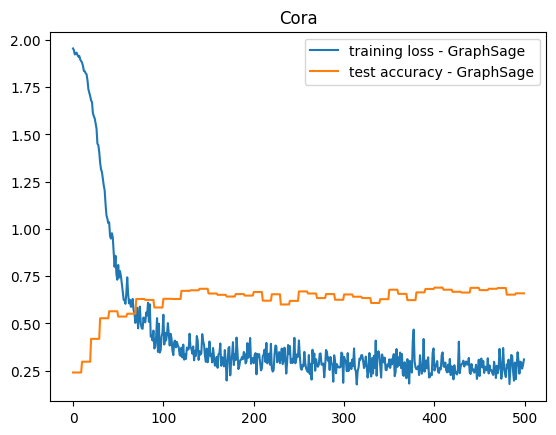

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.005},
    ]:
        args = objectview(args)
        for model in ['GraphSage']:
            args.model_type = model


            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset")
            test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

            print("Maximum test set accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            # Run test for our best model to save the predictions!
            test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
            print()

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()


# [OPTIONAL CHALLENGE] Question 9: What is the maximum accuracy obtained on the test set for GraphSage? (the FABULOUS prize)

Running the cell above will show the results of your best model and save your best model's predictions to a file named *CORA-Node-GraphSage.csv*.

As we have seen before you can view this file by clicking on the *Folder* icon on the left side pannel. When you sumbit your assignment, you will have to download this file and attatch it to your submission. Please submit BOTH the ipynb file and the csv file, named as *CS4099_Colab_4.ipynb* and *CORA-Node-GraphSage.csv*.

In this question, you are challenged to change the GNN architecture however you like in order to squeeze the best performance possible on the test data set. You are limited to use ONLY layers that we have discussed in class. You must be able to explain what you did.

ATTENTION: To participate in this challenge, you must submit your solutions by 3:30 PM ET Thursday March 6, so that the winner can be revealed in our last lecture!




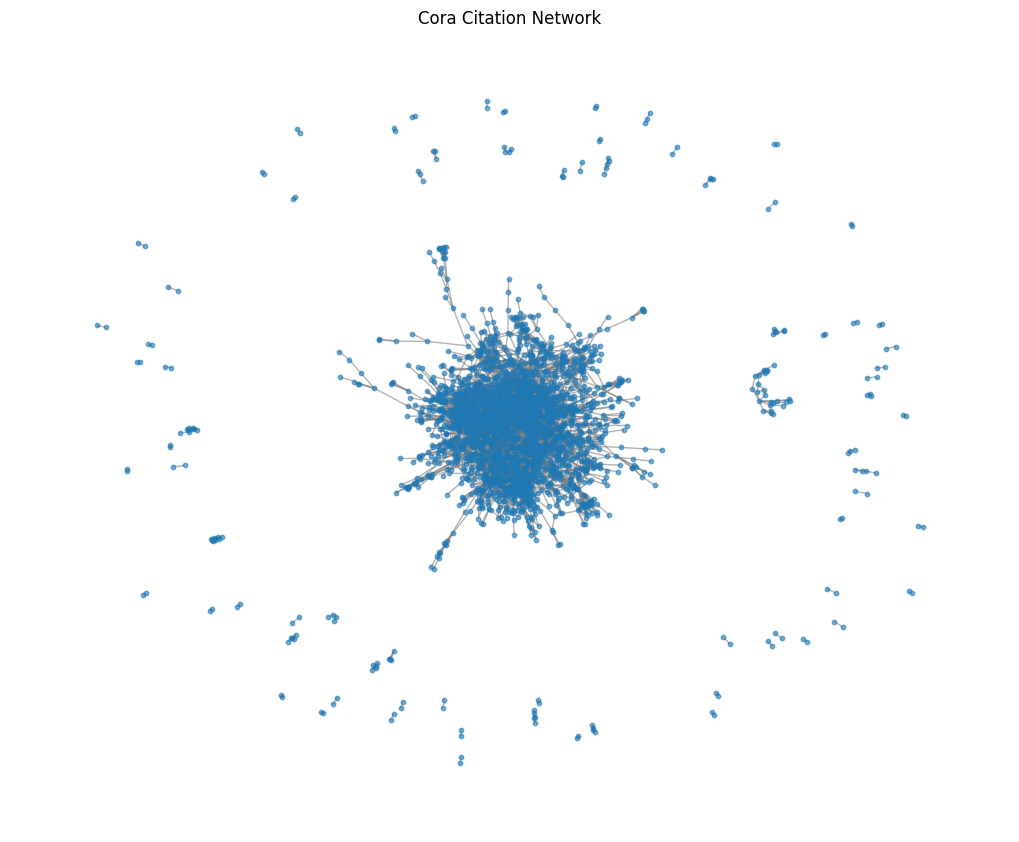

In [12]:
# Step 1: EDA Dataset

# 1: Visualize the graph
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

dataset = Planetoid(root='/tmp/cora', name='Cora')
data = dataset[0]  

G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(10, 8))
nx.draw(G, node_size=10, alpha=0.6, edge_color="gray")
plt.title("Cora Citation Network")
plt.show()


In [13]:
# 2. Large connected component

# Find all connected components
components = list(nx.connected_components(G))

# Identify the largest component
largest_component = max(components, key=len)
largest_component_nodes = set(largest_component)

# Identify outlier nodes (nodes not in the largest component)
outliers = [node for component in components if component != largest_component for node in component]

print(f"Total nodes in graph: {G.number_of_nodes()}")
print(f"Nodes in largest component: {len(largest_component_nodes)}")
print(f"Outlier nodes: {len(outliers)}")

Total nodes in graph: 2708
Nodes in largest component: 2485
Outlier nodes: 223


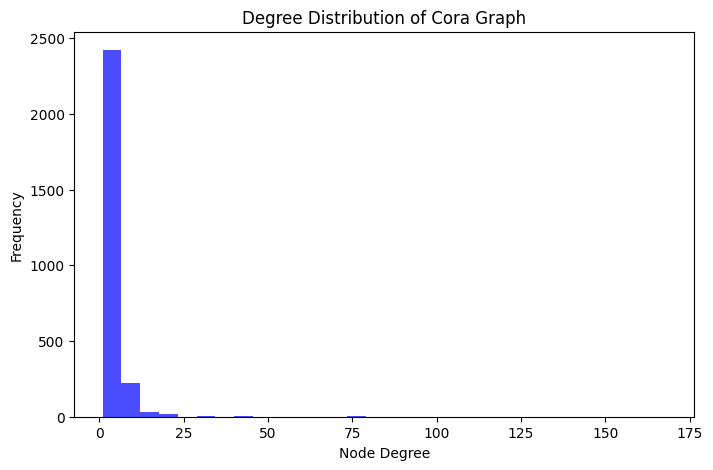

In [14]:
# 3. Node degree distribution

degrees = [val for (node, val) in G.degree()]
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=30, color='blue', alpha=0.7)
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Cora Graph")
plt.show()


### The plots above shows that nodes have very low degree and just only few nodes have high degree => Non-normality. 
### This is explainable since there in research paper lots of paper will have just 1-2 citations where the "revolutionize" research such as GPT model tend to have lots of citations.
###     => For this dataset, we can see hubs nodes is very important since it help model generalization, aggregate information and message passing. However it may also cause to overfit if few high degree nodes dominate. Next, nodes with few neighbor have limited information flow. 

In [23]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree


class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList() 

        self.convs.append(conv_model(input_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))


        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)  # Apply BatchNorm

            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [24]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = True, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here!
        # Define the (PyTorch) layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated
        #            message from neighbors.
        # Don't forget the bias as part of the linear layers!
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        # YOUR CODE HERE

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)
        
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here!
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. Call the propagate function to conduct the message passing.
        #    1.1 See the description of propagate above or the following link for more information:
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We will only use the representation for neighbor nodes (x_j), so by default
        #        we pass the same representation for central and neighbor nodes as x=(x, x).
        # 2. Update our node embedding with skip connection from the previous layer.
        # 3. If normalize is set, do L-2 normalization (defined in
        #    torch.nn.functional)
        #
        # Our implementation is ~4-5 lines, but don't worry if you deviate from this.
        # YOUR CODE HERE
        
        
        out = self.propagate(edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(out)

        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)
        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here!
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on
        # what message each neighboring node passes.
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        # YOUR CODE HERE
        
        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here!
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter:
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        # YOUR CODE HERE
        
        out = scatter(inputs, index, dim=0, dim_size=dim_size, reduce="max") 
        ############################################################################

        return out


In [25]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [26]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):

    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes,
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])

    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


Node task. test set size: 1000



Training: 100%|██████████| 500/500 [02:12<00:00,  3.76Epochs/s]


Maximum test set accuracy: 0.772
Minimum loss: 0.0002651685499586165
Saving Model Predictions for Model Type GraphSage



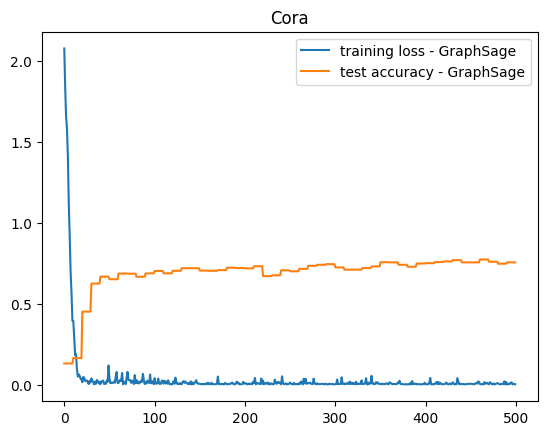

In [28]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'batch_size': 128, 'hidden_dim': 128, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-4, 'lr': 0.005},
    ]:
        args = objectview(args)
        for model in ['GraphSage']:
            args.model_type = model


            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset")
            test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

            print("Maximum test set accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            # Run test for our best model to save the predictions!
            test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
            print()

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()


In [83]:
import os
import itertools
import torch
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid

# Define object view to convert dict to object attributes
class objectview:
    def __init__(self, d):
        self.__dict__ = d

# Define hyperparameter grid
param_grid = {
    'num_layers': [2, 3],  # Test different numbers of layers
    'hidden_dim': [32, 64, 128],  # Vary hidden dimensions
    'dropout': [0.3, 0.6],  # Experiment with dropout rates
    'epochs': [300, 500],  # Number of training epochs
    'lr': [0.005, 0.01],  # Learning rates
    'weight_decay': [5e-4, 1e-3],  # Regularization
    'batch_size': [128],  # Keeping fixed for now
    'opt': ['adam'],  # Using Adam optimizer
    'opt_scheduler': ['none'],  # No scheduler for now
    'opt_restart': [0],  # No restart
}

# Generate all possible hyperparameter combinations
hyperparameter_combinations = list(itertools.product(*param_grid.values()))

best_acc = 0.0
best_params = None

# Iterate through each hyperparameter combination
for param_set in hyperparameter_combinations:
    args_dict = {key: value for key, value in zip(param_grid.keys(), param_set)}
    args_dict.update({'model_type': 'GraphSage', 'dataset': 'cora'})  # Fixed parameters
    args = objectview(args_dict)

    # Load dataset
    if args.dataset == 'cora':
        dataset = Planetoid(root='/tmp/cora', name='Cora')
    else:
        raise NotImplementedError("Unknown dataset")

    # Train model
    test_accs, losses, best_model, acc, test_loader = train(dataset, args)

    # Track best model
    if max(test_accs) > best_acc:
        best_acc = max(test_accs)
        best_params = args_dict

    # Print results for this configuration
    print(f"Params: {args_dict}")
    print(f"Max Test Accuracy: {max(test_accs):.4f}")
    print(f"Min Loss: {min(losses):.4f}")
    print()

# Display the best hyperparameter configuration
print("Best Hyperparameters Found:")
print(best_params)
print(f"Best Accuracy: {best_acc:.4f}")


Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:14<00:00, 20.54Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5990
Min Loss: 0.0053

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:13<00:00, 22.33Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5430
Min Loss: 0.0048

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:13<00:00, 21.97Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6280
Min Loss: 0.0037

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:14<00:00, 20.36Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6230
Min Loss: 0.0070

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:23<00:00, 20.93Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6080
Min Loss: 0.0027

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:24<00:00, 20.67Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5940
Min Loss: 0.0047

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:23<00:00, 21.62Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6870
Min Loss: 0.0041

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:23<00:00, 21.10Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6100
Min Loss: 0.0075

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:13<00:00, 21.53Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6910
Min Loss: 0.3559

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:13<00:00, 21.57Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6680
Min Loss: 0.3561

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:14<00:00, 21.31Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7070
Min Loss: 0.3204

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:13<00:00, 21.58Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6930
Min Loss: 0.4272

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:23<00:00, 21.04Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6730
Min Loss: 0.2671

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:25<00:00, 19.70Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6750
Min Loss: 0.1979

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:31<00:00, 15.78Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7440
Min Loss: 0.3246

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:32<00:00, 15.52Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6880
Min Loss: 0.3172

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:21<00:00, 13.73Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6240
Min Loss: 0.0002

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:25<00:00, 11.99Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5770
Min Loss: 0.0004

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:26<00:00, 11.47Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6060
Min Loss: 0.0006

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:25<00:00, 11.85Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6180
Min Loss: 0.0015

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:37<00:00, 13.37Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5690
Min Loss: 0.0003

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:31<00:00, 15.87Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6220
Min Loss: 0.0005

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:31<00:00, 15.80Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6670
Min Loss: 0.0004

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:31<00:00, 15.63Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6190
Min Loss: 0.0009

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:21<00:00, 14.18Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7060
Min Loss: 0.0337

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:21<00:00, 13.69Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6720
Min Loss: 0.0311

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:21<00:00, 13.90Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7280
Min Loss: 0.0650

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:22<00:00, 13.47Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6660
Min Loss: 0.0383

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:33<00:00, 14.73Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6840
Min Loss: 0.0336

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:41<00:00, 11.91Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6040
Min Loss: 0.0342

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:33<00:00, 15.02Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7300
Min Loss: 0.0327

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:31<00:00, 15.89Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7270
Min Loss: 0.0337

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:31<00:00,  9.45Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6170
Min Loss: 0.0000

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:30<00:00,  9.71Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5810
Min Loss: 0.0000

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:30<00:00,  9.96Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5930
Min Loss: 0.0001

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:29<00:00, 10.01Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6100
Min Loss: 0.0002

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:49<00:00, 10.04Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6030
Min Loss: 0.0001

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:50<00:00,  9.92Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6530
Min Loss: 0.0000

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:50<00:00,  9.99Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6100
Min Loss: 0.0001

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:50<00:00,  9.83Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5790
Min Loss: 0.0004

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:30<00:00,  9.95Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7290
Min Loss: 0.0035

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:30<00:00,  9.95Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6990
Min Loss: 0.0034

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:30<00:00,  9.99Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7200
Min Loss: 0.0010

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:30<00:00,  9.96Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7040
Min Loss: 0.0077

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:50<00:00,  9.86Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7410
Min Loss: 0.0016

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:50<00:00,  9.97Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7050
Min Loss: 0.0032

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:50<00:00,  9.94Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7160
Min Loss: 0.0027

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:50<00:00,  9.97Epochs/s]


Params: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7170
Min Loss: 0.0047

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:15<00:00, 19.18Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6530
Min Loss: 0.0147

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:15<00:00, 19.61Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6510
Min Loss: 0.0240

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:15<00:00, 19.79Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7400
Min Loss: 0.0071

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:15<00:00, 19.93Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7150
Min Loss: 0.0104

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:26<00:00, 19.08Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6530
Min Loss: 0.0113

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:27<00:00, 18.49Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6870
Min Loss: 0.0199

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:27<00:00, 18.49Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6590
Min Loss: 0.0072

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:25<00:00, 19.39Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7250
Min Loss: 0.0152

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:15<00:00, 19.32Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5860
Min Loss: 0.7999

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:15<00:00, 19.21Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5080
Min Loss: 0.9955

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:16<00:00, 18.21Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.4760
Min Loss: 0.9998

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:19<00:00, 15.73Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5450
Min Loss: 0.7857

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:26<00:00, 18.79Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5350
Min Loss: 0.7270

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:26<00:00, 18.83Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.4690
Min Loss: 0.6875

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:25<00:00, 19.83Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.4900
Min Loss: 0.7136

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:25<00:00, 19.61Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6140
Min Loss: 0.6321

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:21<00:00, 14.19Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7010
Min Loss: 0.0010

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:21<00:00, 14.19Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6770
Min Loss: 0.0016

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:21<00:00, 14.21Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6790
Min Loss: 0.0014

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:21<00:00, 14.26Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6760
Min Loss: 0.0036

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:37<00:00, 13.25Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7190
Min Loss: 0.0009

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:39<00:00, 12.57Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6810
Min Loss: 0.0013

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:39<00:00, 12.50Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6770
Min Loss: 0.0004

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:41<00:00, 12.16Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7090
Min Loss: 0.0028

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:24<00:00, 12.17Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7330
Min Loss: 0.1894

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:25<00:00, 11.84Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6900
Min Loss: 0.2019

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:22<00:00, 13.06Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6280
Min Loss: 0.3226

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:26<00:00, 11.34Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6740
Min Loss: 0.1819

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:41<00:00, 12.11Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7320
Min Loss: 0.0890

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:46<00:00, 10.76Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6960
Min Loss: 0.0956

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:41<00:00, 12.01Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7140
Min Loss: 0.1001

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:41<00:00, 12.00Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7210
Min Loss: 0.0925

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:40<00:00,  7.46Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.5480
Min Loss: 0.0002

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:37<00:00,  7.90Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6120
Min Loss: 0.0003

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:36<00:00,  8.31Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6640
Min Loss: 0.0003

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:38<00:00,  7.70Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6520
Min Loss: 0.0011

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:59<00:00,  8.45Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6640
Min Loss: 0.0001

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:04<00:00,  7.78Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6930
Min Loss: 0.0003

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:02<00:00,  7.94Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6320
Min Loss: 0.0003

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:06<00:00,  7.50Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6290
Min Loss: 0.0008

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:38<00:00,  7.72Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7370
Min Loss: 0.0100

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:37<00:00,  8.00Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 300, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7110
Min Loss: 0.0138

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:36<00:00,  8.31Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7250
Min Loss: 0.0165

Node task. test set size: 1000



Training: 100%|██████████| 300/300 [00:40<00:00,  7.44Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 300, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.7220
Min Loss: 0.0311

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:12<00:00,  6.93Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6490
Min Loss: 0.0045

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:07<00:00,  7.36Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 500, 'lr': 0.005, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6850
Min Loss: 0.0074

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:06<00:00,  7.49Epochs/s]


Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6770
Min Loss: 0.0095

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:06<00:00,  7.57Epochs/s]

Params: {'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Max Test Accuracy: 0.6870
Min Loss: 0.0180

Best Hyperparameters Found:
{'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 500, 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 128, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'model_type': 'GraphSage', 'dataset': 'cora'}
Best Accuracy: 0.7440
